#Задание 1. Ответить на вопросы
1.	Что такое предварительно обученная сеть?

Предварительно обученная сеть - это предобученная модель, которая тренировалась на каком-то большом, как правило универсальном, наборе данных.

2.	Архитектура VGG16.

Архитектура VGG16 — модель сверточной нейронной сети, предложенная K. Simonyan и A. Zisserman из Оксфордского университета в статье “Very Deep Convolutional Networks for Large-Scale Image Recognition”. Модель достигает точности 92.7% — топ-5, при тестировании на ImageNet в задаче распознавания объектов на изображении.

3.	Приемы использования предварительно обученных сетей: выделение признаков (featureextraction) и дообучение (fine-tuning).

Выделение признаков заключается в использовании неизменной сверточной основы архитектуры и создании своего собственного классификатора. Как правило, в моделях CNN последний слой —  полносвязный. В feature extraction мы отказываемся от этого слоя и реализуем свой, например через TensorFlow.

В отличие от feature extraction, суть дообучения (Fine Tuning) заключается в размораживании последних слоев нейронной сети и их обучении. Таким образом, корректируются слои, которые имеют наиболее абстрактные представления. Производя дообучение только нескольких слоев, мы уменьшаем риск переобучения (overfitting). И самое главное, это позволяет сделать текущую модель ещё более подходящей к нашей задаче.


#Задание 2. Выполнить задачу классификации изображений, используя предварительно обученную модель.

Загрузка и предварительная обработка данных

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(train_data, train_labels), (val_data, val_labels) = cifar10.load_data()

train_data = train_data / 255.0
val_data = val_data / 255.0

train_labels = to_categorical(train_labels, num_classes=10)
val_labels = to_categorical(val_labels, num_classes=10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Загрузка предварительно обученной модели и добавление пользовательских слоев

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

pretrain_model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Заморозка предварительно обученных слоев

In [3]:
for layer in base_model.layers:
    layer.trainable = False

pretrain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Обучение пользовательских слоев

In [4]:
history_pretrain = pretrain_model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.4864 - loss: 1.4541 - val_accuracy: 0.5638 - val_loss: 1.2391
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6004 - loss: 1.1318 - val_accuracy: 0.5818 - val_loss: 1.1858
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6276 - loss: 1.0610 - val_accuracy: 0.5946 - val_loss: 1.1527
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6527 - loss: 0.9921 - val_accuracy: 0.6095 - val_loss: 1.1064
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6724 - loss: 0.9371 - val_accuracy: 0.6144 - val_loss: 1.0992
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6895 - loss: 0.8783 - val_accuracy: 0.6147 - val_loss: 1.1124
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7076 - loss: 0.8278 - val_accuracy: 0.6207 - val_loss: 1.1033
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7254 - loss: 

Разморозка некоторых слоев для более точной настройки

In [5]:
for layer in pretrain_model.layers[-4:]:
    layer.trainable = True

pretrain_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Переобучение модели

In [6]:
history_finetune = pretrain_model.fit(train_data, train_labels, epochs=5, validation_data=(val_data, val_labels))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8089 - loss: 0.5656 - val_accuracy: 0.6445 - val_loss: 1.1200
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8314 - loss: 0.5142 - val_accuracy: 0.6425 - val_loss: 1.1258
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8389 - loss: 0.4931 - val_accuracy: 0.6431 - val_loss: 1.1277
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8425 - loss: 0.4853 - val_accuracy: 0.6416 - val_loss: 1.1329
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8505 - loss: 0.4669 - val_accuracy: 0.6446 - val_loss: 1.1374


Оценка и визуализация модели

313/313 - 2s - 7ms/step - accuracy: 0.6446 - loss: 1.1374
Validation Accuracy: 0.6446
Validation Loss: 1.1374


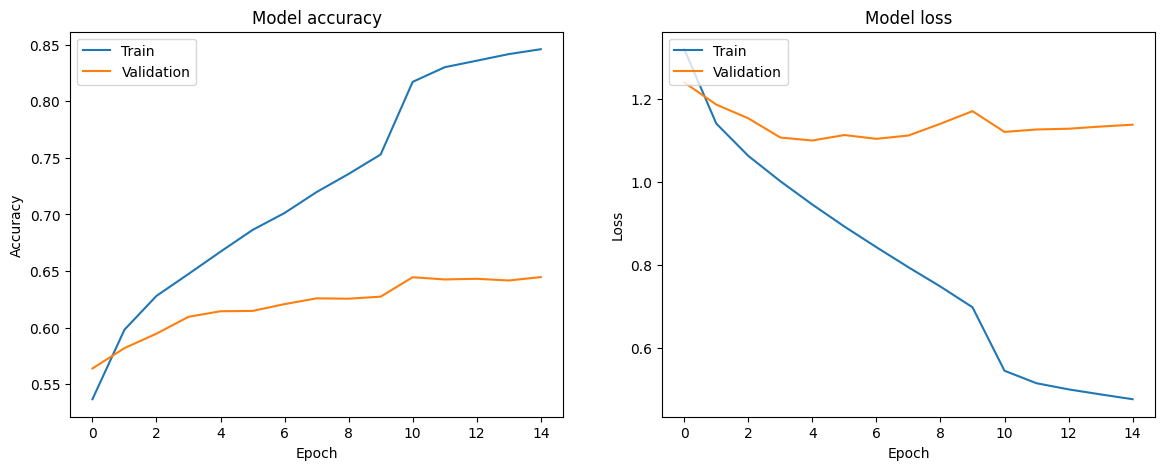

In [7]:
val_loss, val_accuracy = pretrain_model.evaluate(val_data, val_labels, verbose=2)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_pretrain.history['accuracy'] + history_finetune.history['accuracy'])
plt.plot(history_pretrain.history['val_accuracy'] + history_finetune.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_pretrain.history['loss'] + history_finetune.history['loss'])
plt.plot(history_pretrain.history['val_loss'] + history_finetune.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()